In [1]:
#Soho is main 

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from tcn import TCN
import time
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from keras.preprocessing import sequence
from keras.models import Sequential , load_model , Model
from keras.layers import Dense, Dropout , LSTM , Bidirectional ,GRU ,Flatten,Add,BatchNormalization
from keras_layer_normalization import LayerNormalization
from keras.initializers import  glorot_normal, RandomUniform
from keras import optimizers,Input
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [3]:
df = pd.read_csv("Mode2_bike_one.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

(735, 13) (662, 13) (97, 13)


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

  0%|          | 0/638 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/73 [00:00<?, ?it/s]

Train size:
(638, 24, 12) (638,)
Test size:
(73, 24, 12) (73,)


In [4]:
from keras.layers import Concatenate
init = glorot_normal(seed=None) # 給 GRU
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer

def Encoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = Flatten()(layer)
    
    shortcut2 = layer
    layer = Dense(16,kernel_initializer=init_d)(layer)
    layer = Dropout(0.3)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Decoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = LayerNormalization()(layer)
    
    layer = Flatten()(layer)
    shortcut2 = layer
    layer = Dense(16,kernel_initializer=init_d)(layer)
    layer = Dropout(0.3)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Bi_GRU(layer,unit):
    output = Bidirectional(GRU(unit, dropout=0.2, recurrent_dropout=0.25, return_sequences=True,
                            kernel_initializer=init))(layer)
    return output

#start = Input(shape = (x_train.shape[1],x_train.shape[2]))
start = Input(shape = (x_train.shape[1:]))
start2 = Input(shape = (x_train.shape[1:]))
x = Bi_GRU(start,32)
x = Encoder(x)

y = Bi_GRU(start2,16)
y = Decoder(y)

Merge = Add()([x,y])
Last = Dense(1)(Merge)
model = Model([start,start2] , Last)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 24, 12)       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 24, 32)       2784        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 24, 12)       0                                            
__________________________________________________________________________________________________
seq_self_attention_2 (SeqSelfAt (None, 24, 32)       1025        bidirectional_2[0][0]            
____________________________________________________________________________________________

In [5]:
opt = optimizers.Adam(lr=0.0009)
print('Train...')
model.compile(optimizer = opt , loss="mse")
#model.compile(optimizer = "adam" , loss="mse")
history = model.fit([x_train,x_train], y_train, epochs = 500, batch_size=24, validation_split=0.1, shuffle=True)
# history = model.fit(x_train, y_train, epochs = 500, batch_size=6, validation_split=0.1, shuffle=True)
model.summary()
#Save Model
model.save('GRU_Single_Attention_model_one.h5')  # creates a HDF5 file 
del model


Train...
Train on 574 samples, validate on 64 samples
Epoch 1/500
574/574 [==============================] - 4s 7ms/step - loss: 4.4053 - val_loss: 1.9033
Epoch 2/500
574/574 [==============================] - 2s 3ms/step - loss: 2.4931 - val_loss: 4.8548
Epoch 3/500
574/574 [==============================] - 2s 3ms/step - loss: 2.3254 - val_loss: 5.2220
Epoch 4/500
574/574 [==============================] - 2s 3ms/step - loss: 2.0933 - val_loss: 3.0416
Epoch 5/500
574/574 [==============================] - 2s 3ms/step - loss: 2.1068 - val_loss: 7.0905
Epoch 6/500
574/574 [==============================] - 2s 3ms/step - loss: 2.0903 - val_loss: 1.9021
Epoch 7/500
574/574 [==============================] - 2s 3ms/step - loss: 2.0595 - val_loss: 3.6946
Epoch 8/500
574/574 [==============================] - 2s 3ms/step - loss: 2.0048 - val_loss: 2.7032
Epoch 9/500
574/574 [==============================] - 2s 3ms/step - loss: 1.9815 - val_loss: 1.6653
Epoch 10/500
574/574 [===============

Epoch 81/500
574/574 [==============================] - 2s 3ms/step - loss: 1.0445 - val_loss: 2.2493
Epoch 82/500
574/574 [==============================] - 2s 3ms/step - loss: 0.9943 - val_loss: 3.2747
Epoch 83/500
574/574 [==============================] - 2s 3ms/step - loss: 0.9880 - val_loss: 1.7165
Epoch 84/500
574/574 [==============================] - 2s 3ms/step - loss: 0.9806 - val_loss: 3.0915
Epoch 85/500
574/574 [==============================] - 2s 3ms/step - loss: 0.9744 - val_loss: 2.0772
Epoch 86/500
574/574 [==============================] - 2s 3ms/step - loss: 1.0039 - val_loss: 2.5839
Epoch 87/500
574/574 [==============================] - 2s 3ms/step - loss: 1.0051 - val_loss: 1.9273
Epoch 88/500
574/574 [==============================] - 2s 3ms/step - loss: 0.9979 - val_loss: 3.0769
Epoch 89/500
574/574 [==============================] - 2s 3ms/step - loss: 0.9731 - val_loss: 2.7885
Epoch 90/500
574/574 [==============================] - 2s 3ms/step - loss: 0.9776

574/574 [==============================] - 2s 3ms/step - loss: 0.4285 - val_loss: 1.0245
Epoch 240/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4504 - val_loss: 1.3674
Epoch 241/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4387 - val_loss: 1.6412
Epoch 242/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4229 - val_loss: 1.0873
Epoch 243/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4566 - val_loss: 0.9178
Epoch 244/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4436 - val_loss: 1.0048
Epoch 245/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4196 - val_loss: 0.8116
Epoch 246/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4627 - val_loss: 1.1506
Epoch 247/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4190 - val_loss: 0.8798
Epoch 248/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4713 - v

574/574 [==============================] - 2s 3ms/step - loss: 0.2435 - val_loss: 0.5014
Epoch 398/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2253 - val_loss: 0.6273
Epoch 399/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2448 - val_loss: 0.4242
Epoch 400/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2454 - val_loss: 0.5703
Epoch 401/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2371 - val_loss: 0.5048
Epoch 402/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2391 - val_loss: 0.4790
Epoch 403/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2202 - val_loss: 0.4492
Epoch 404/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2297 - val_loss: 0.7345
Epoch 405/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2652 - val_loss: 0.4448
Epoch 406/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2501 - v

Predict time:  0.5109086036682129
RMSE2:  9.472479958007836
MAE2:  6.813250662937556
R-square2:  -0.6960473817982364


Text(0, 0.5, 'mse score')

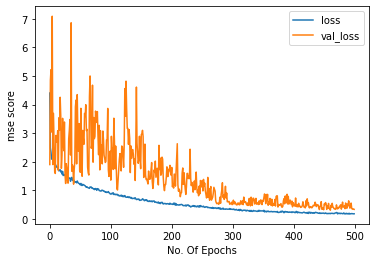

In [6]:
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
model = load_model('GRU_Single_Attention_model_one.h5', custom_objects=custom_ob)
t1 = time.time()
y_pred2 = model.predict([x_test,x_test])
#y_pred2 = model.predict(x_test)
#y_pred = model.predict(x_train)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred2)#Undo scaling
rmse_lstm2 = np.sqrt(mean_squared_error(y_test, y_pred2))
#rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred))
#print('RMSE: ',rmse_lstm)
print('RMSE2: ',rmse_lstm2)
mae2 = mean_absolute_error(y_test, y_pred2)
#mae = mean_absolute_error(y_train, y_pred)
#print('MAE: ',mae)
print('MAE2: ',mae2)
r22 =  r2_score(y_test, y_pred2)
# r2 =  r2_score(y_train, y_pred)
# print('R-square: ',r2)
print('R-square2: ',r22)

# n = len(y_test)
# p = 12
# Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
# Adj_r22 = 1-(1-r22)*(n-1)/(n-p-1)
# print('Adj R-square: ',Adj_r2)
# print('Adj R-square2: ',Adj_r22)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")